# Explore here

In [2]:
# Your code here
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import numpy as np 
import statsmodels.api as sm



In [3]:
#Vizualisamos dataset: 
df = pd.read_csv('/workspaces/pauline-Serie-Temporal-Alternativa/data/raw/sales.csv')
df.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


In [4]:
df.shape 

(366, 2)

In [5]:
df.dtypes

date      object
sales    float64
dtype: object

In [6]:
#Sales como float está bien, nos falta poner date en formato datime: 
df["date"] = pd.to_datetime(df.date)
df.dtypes

date     datetime64[ns]
sales           float64
dtype: object

In [7]:
#Hay 366 linea pues parece ser un df de numeros sobre un año, vamos a ver si es así, y que rango de fecha : 
 
#Fecha max y min : 
print(df.date.max())
print(df.date.min())
#Diferencia en días dentro de nuestro df : 
(df.date.max()-df.date.min()).days

2023-09-03 17:10:08.079328
2022-09-03 17:10:08.079328


365

In [8]:
df.date.nunique()

366

In [9]:
#Tensor = cada día a las 17h10 tenemos la nueva info sales. En ese df tenemos resultados de 1 año a partir del 03/09/22

#Hay 366 porque el 03/09 la tenemos 2 veces, en 22 y en 23, borro la de 2023 para tener exactamente analisis de 1 año:
df = df[df['date'] != pd.Timestamp('2023-09-03 17:10:08.079328')]
print(df.shape)




(365, 2)


In [10]:
#chequeamos igual si hay duplicados, a ver si nos faltaría una fecha : 
df.date.duplicated().sum() 

np.int64(0)

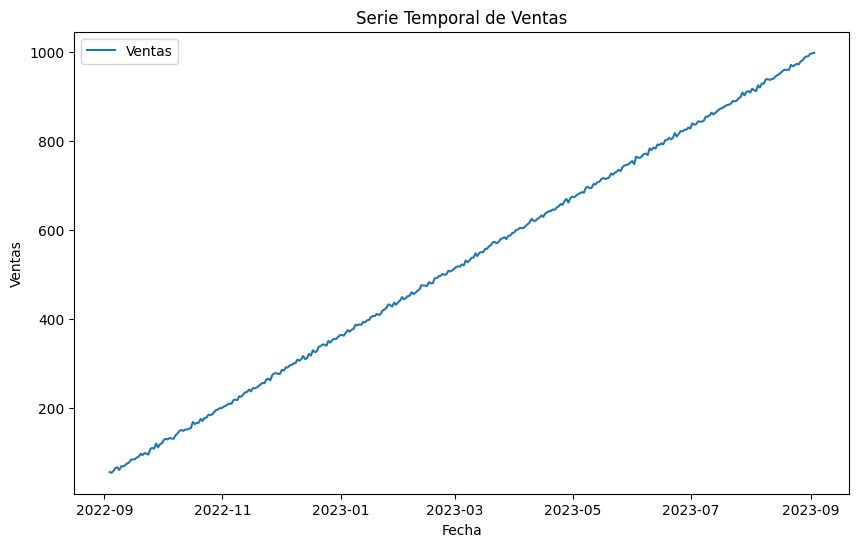

In [11]:
#Ahora podemos plotear, primero establecemos date como indice (=reemplazar el índice numérico con los valores de fechas, e lugar de ir de 0 a ... ira de fecha en fecha): 
df.set_index('date', inplace=True)

#Hacemos el gráfico :

plt.figure(figsize=(10, 6))
plt.plot(df.index, df['sales'], label='Ventas')
plt.title('Serie Temporal de Ventas')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.show()




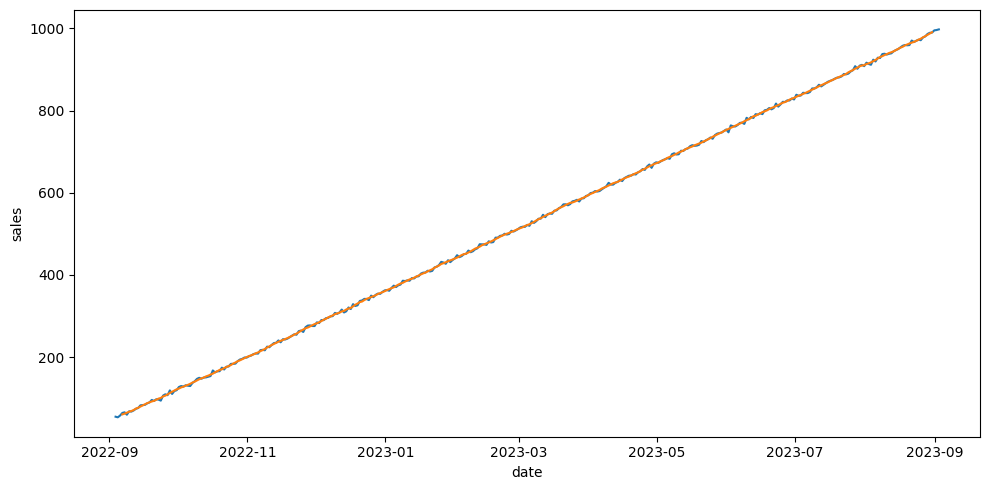

In [12]:
#Tendencia: vamos a verlo por semana: 

decomposition = seasonal_decompose(df['sales'], period=7)
decomposition

trend = decomposition.trend

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = df['sales'])
sns.lineplot(data = trend)

plt.tight_layout()

plt.show()

[91, 182, 273, 365]


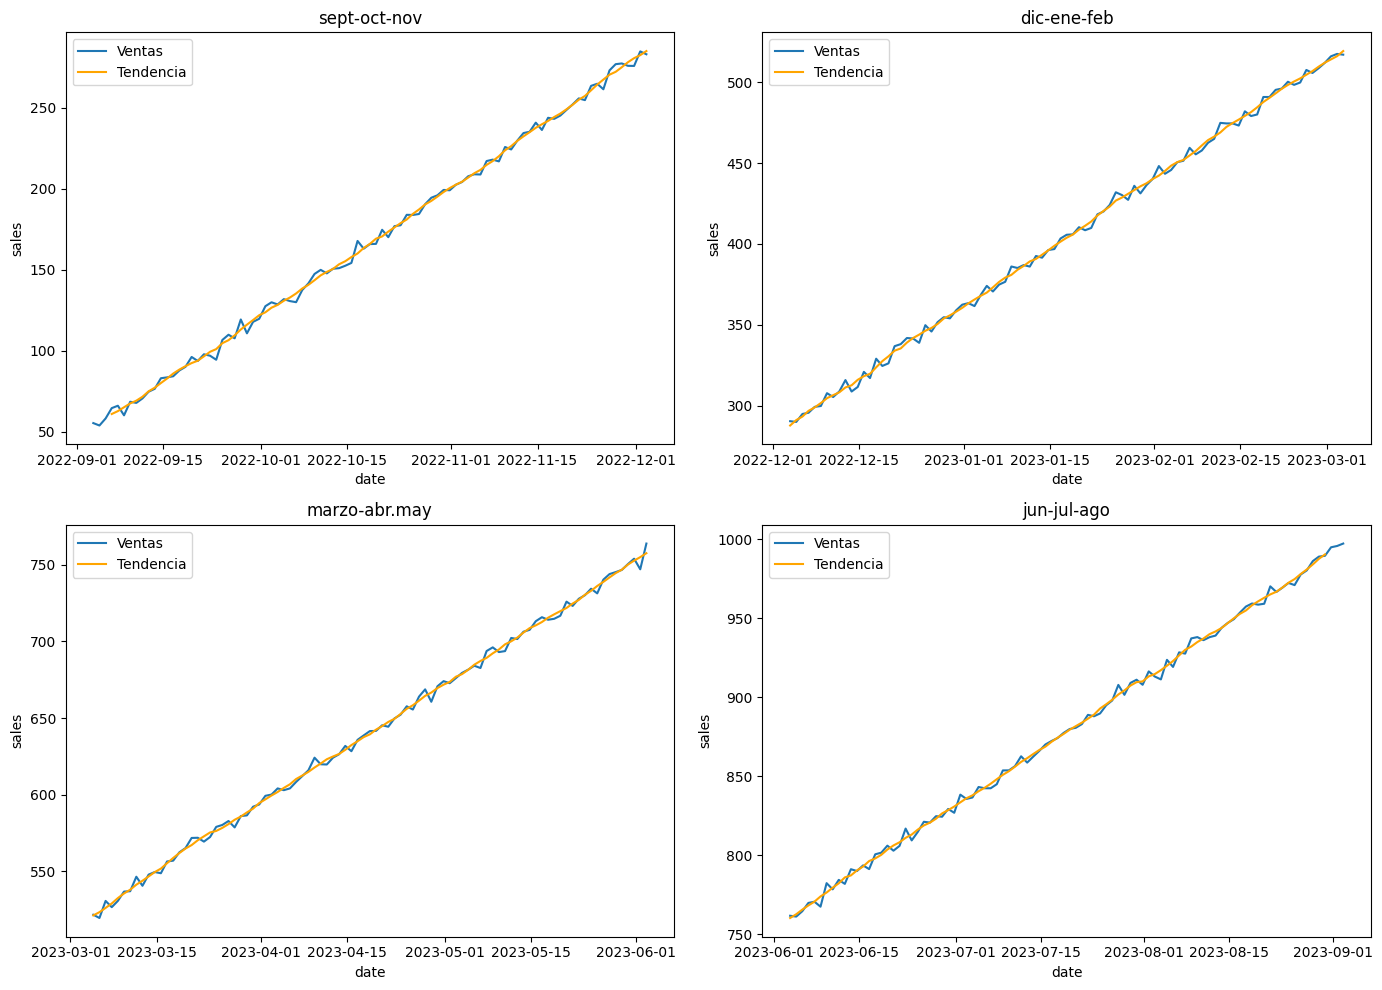

In [13]:
#No se ve muy bien pues voy a cortar en 4 subplots : 


#Definimos los cortes para los subgráficos (4 partes)
days_split = [91, 91, 91, 92]  #(=365 jours)


#Definimos los índices de los cortes de los periodos, dentro del df
indices = [sum(days_split[:i]) for i in range(1, 5)]
#chequeamo : 
print(indices)

#Subplots :
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

#Periodo 1:
sns.lineplot(data=df['sales'][:indices[0]], ax=axs[0, 0], label='Ventas')
sns.lineplot(data=trend[:indices[0]], ax=axs[0, 0], label='Tendencia', color='orange')
axs[0, 0].set_title('sept-oct-nov')
axs[0, 0].legend()

#Periodo 2:
sns.lineplot(data=df['sales'][indices[0]:indices[1]], ax=axs[0, 1], label='Ventas')
sns.lineplot(data=trend[indices[0]:indices[1]], ax=axs[0, 1], label='Tendencia', color='orange')
axs[0, 1].set_title('dic-ene-feb')
axs[0, 1].legend()

#Periodo 3
sns.lineplot(data=df['sales'][indices[1]:indices[2]], ax=axs[1, 0], label='Ventas')
sns.lineplot(data=trend[indices[1]:indices[2]], ax=axs[1, 0], label='Tendencia', color='orange')
axs[1, 0].set_title('marzo-abr.may')
axs[1, 0].legend()

#Periodo 4
sns.lineplot(data=df['sales'][indices[2]:], ax=axs[1, 1], label='Ventas')
sns.lineplot(data=trend[indices[2]:], ax=axs[1, 1], label='Tendencia', color='orange')
axs[1, 1].set_title('jun-jul-ago')
axs[1, 1].legend()

plt.tight_layout()
plt.show()

Todo es banstante estable a lo largo del año, no se puede concluir que hay temporalidad.

In [14]:
#Ahora vamos a proceder a identificar test y train
#usaremos datos de los 9 primeros meses para train y 3 ultimos para test : para que el modelo aprenda de una cantidad representativa de datos, y luego se evalúe el periodo más reciente
df_train, df_test = df.iloc[:274], df.iloc[-91:]



In [15]:
df_train

,sales
date,
2022-09-03 17:10:08.079328,55.292157
2022-09-04 17:10:08.079328,53.803211
2022-09-05 17:10:08.079328,58.141693
2022-09-06 17:10:08.079328,64.530899
2022-09-07 17:10:08.079328,66.013633
...,...
2023-05-30 17:10:08.079328,750.429187
2023-05-31 17:10:08.079328,753.936865
2023-06-01 17:10:08.079328,747.024687


In [ ]:
n = 7 #7 días consecutivos, el modelo aprendea predecir el 7mo día utilizando los 6 días anteriores.
# X_train = [día 1, día 2, día 3, día 4, día 5, día 6], y
# y_train = día 7, a predecir 

XY_train = np.array([df_train.sales.values[i:i+n] for i in range(len(df_train.sales.values)) if len(df_train.sales.values[i:i+n])==n])
XY_test = np.array([df_test.sales.values[i:i+n] for i in range(len(df_test.sales.values)) if len(df_test.sales.values[i:i+n])==n])
X_train, y_train = XY_train[:,:-1], XY_train[:,-1] # Los primeros 6 días como características y el 7mo como etiqueta
X_test, y_test = XY_test[:,:-1], XY_test[:,-1]


In [18]:
# Crear el modelo de regresión lineal
X_train_const = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train_const)

# Ajustar el modelo a los datos
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.769e+05
Date:                Fri, 28 Feb 2025   Prob (F-statistic):               0.00
Time:                        15:37:30   Log-Likelihood:                -688.10
No. Observations:                 268   AIC:                             1390.
Df Residuals:                     261   BIC:                             1415.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.9160      0.834     10.696      0.0

In [ ]:
#R-squarred de 1 --> sobreajuste ???